# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Device: cuda


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


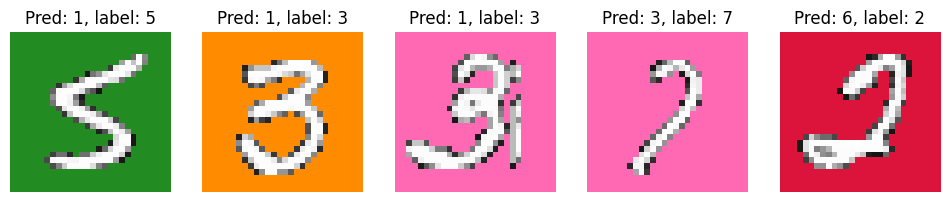

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


28


C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


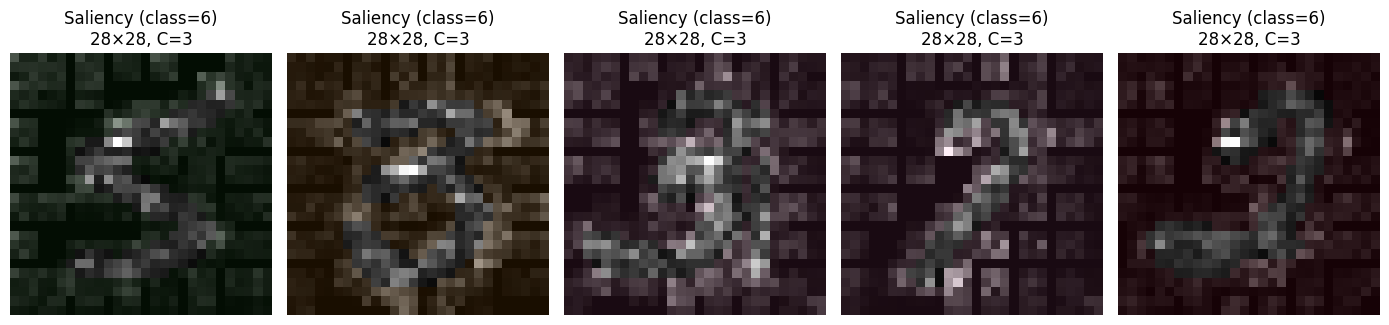

In [6]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from captum.attr import Saliency

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

# --- 1) Detect channels and a working input size ---
def detect_model_io(model, sizes=(28, 32, 64, 96, 128, 160, 192, 224, 256, 320, 384)):
    # channels: read from first Conv2d if present, else assume 3
    in_ch = 3
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            in_ch = m.in_channels
            break
    # find a size that passes forward
    ok_size = None
    with torch.no_grad():
        for s in sizes:
            try:
                _ = model(torch.zeros(1, in_ch, s, s, device=device))
                ok_size = s
                print(ok_size)
                break
            except Exception:
                continue
    if ok_size is None:
        raise RuntimeError("Could not find a compatible square input size. Try adding your training size.")
    return in_ch, ok_size

in_ch, IMG_SIZE = detect_model_io(model)

# --- 2) Build transforms (adjust normalization if you used different stats) ---
if in_ch == 3:
    preprocess = Compose([
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # change to your training stats if needed
    ])
    to_vis = Compose([
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),   # [0,1] for overlay
    ])
else:  # in_ch == 1
    preprocess = Compose([
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
        Normalize(mean=[0.1307], std=[0.3081]),    # MNIST-like; change if different
    ])
    to_vis = Compose([
        Resize((IMG_SIZE, IMG_SIZE)),
        ToTensor(),
    ])

# --- 3) Captum Saliency setup ---
saliency = Saliency(model)

def compute_saliency(img_path, target_class):
    pil = Image.open(img_path).convert("RGB" if in_ch == 3 else "L")
    x = preprocess(pil).unsqueeze(0).to(device)        # model input
    x_vis = to_vis(pil).unsqueeze(0)                   # for overlay

    # gradient wrt chosen class (set target_class=None for predicted class)
    attr = saliency.attribute(x, target=target_class)  # [1,C,H,W]
    sal = attr.abs().squeeze(0).detach().cpu().numpy() # [C,H,W] or [H,W]
    if sal.ndim == 3:
        sal = sal.max(axis=0)                          # reduce channels

    # normalize to [0,1]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

    img_np = x_vis[0].permute(1,2,0).cpu().numpy()     # [H,W,3] or [H,W,1]
    ponderation = 0.1
    overlay = np.clip(ponderation*img_np + (1-ponderation)*sal[...,None], 0, 1)
    return img_np, sal, overlay

# --- 4) Run on your images ---
target_class = 6  # <- set the class you want
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, path in zip(axes, image_files):
    img_np, sal, overlay = compute_saliency(path, target_class)
    if img_np.shape[2] == 1:
        ax.imshow(overlay.squeeze(), cmap="gray")
    else:
        ax.imshow(overlay)
    ax.set_title(f"Saliency (class={target_class})\n{IMG_SIZE}×{IMG_SIZE}, C={in_ch}")
    ax.axis("off")
plt.tight_layout(); plt.show()


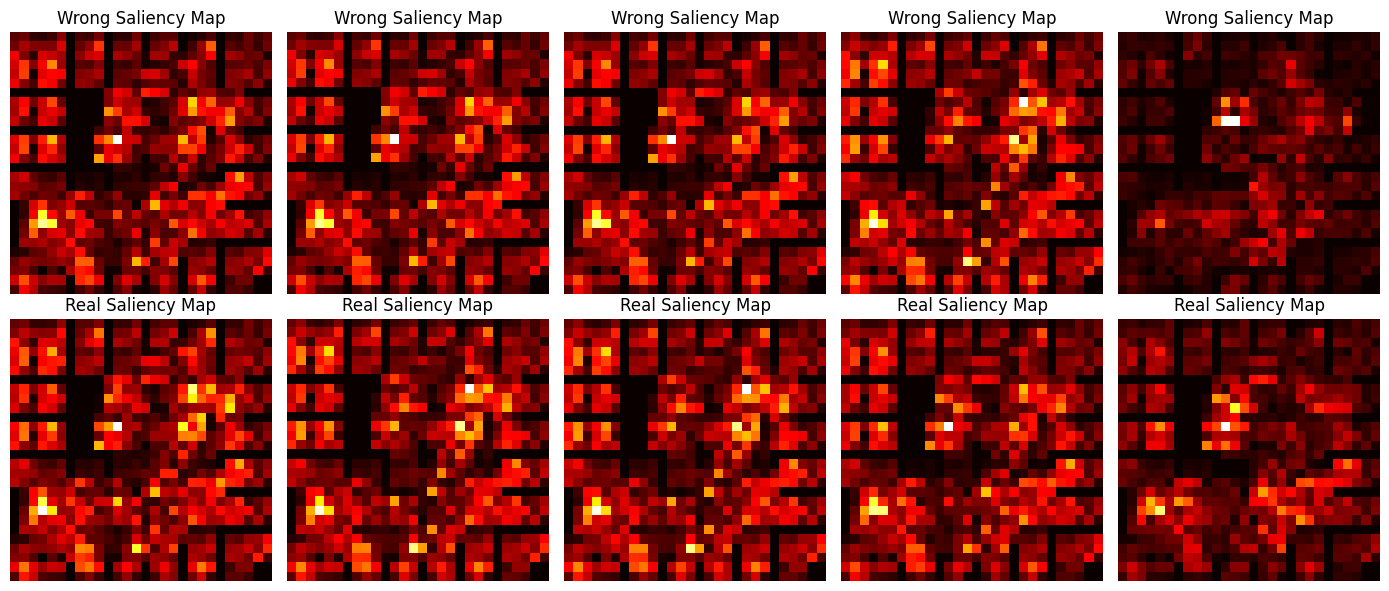

In [7]:
wrong_maps = []
for target_class in [1,1,1,3,6]:
    img_np, sal, overlay = compute_saliency(path, target_class)
    wrong_maps.append(sal)

real_maps = []
for real_class in [5,3,3,7,2]:
    img_np, sal, overlay = compute_saliency(path, real_class)
    real_maps.append(sal)

fig, axes = plt.subplots(2, len(image_files), figsize=(14,6))
for ax, sal in zip(axes[0], wrong_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Wrong Saliency Map")
    ax.axis("off")
for ax, sal in zip(axes[1], real_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Real Saliency Map")
    ax.axis("off")
plt.tight_layout(); plt.show()        

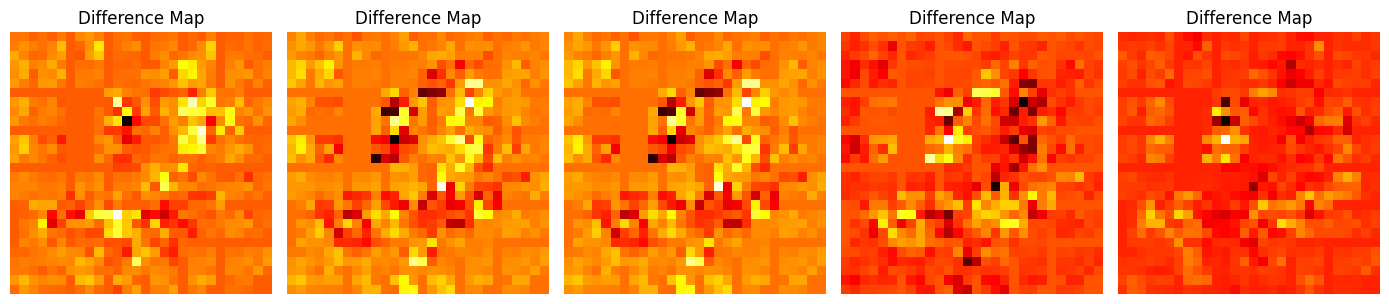

In [8]:
#subtract wrong from real
diff_maps = []
for real_sal, wrong_sal in zip(real_maps, wrong_maps):
    diff = real_sal - wrong_sal
    diff_maps.append(diff)
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, sal in zip(axes, diff_maps):
    ax.imshow(sal, cmap="hot")
    ax.set_title(f"Difference Map")
    ax.axis("off")
plt.tight_layout(); plt.show()

In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

def detect_background_color(img_np, tol=0.05):
    """
    Estimate background color from the image edges using median color.
    img_np: [H,W,3] in [0,1] or [H,W,1] in [0,1]
    Returns bg_color as shape (3,) for RGB or (1,) for grayscale, and a function is_bg(pixels)
    """
    H, W = img_np.shape[:2]
    # collect edge pixels
    top = img_np[0, :, :]
    bottom = img_np[-1, :, :]
    left = img_np[:, 0, :]
    right = img_np[:, -1, :]
    edges = np.concatenate([top, bottom, left, right], axis=0)  # [N,C]

    # background = channel-wise median
    bg_color = np.median(edges, axis=0)

    # distance threshold to consider "background"
    def is_bg(pix):
        # pix [...,C]; Euclidean distance
        d = np.linalg.norm(pix - bg_color, axis=-1)
        return d < tol

    return bg_color, is_bg

def top_k_most_negative_mask(diff, frac=0.40):
    """
    Select up to frac of *all pixels*, but only among negative diffs.
    diff: [H,W] numpy array (can be torch tensor -> use .cpu().numpy())
    """
    if isinstance(diff, torch.Tensor):
        diff = diff.detach().cpu().numpy()
    flat = diff.flatten()
    neg_idx = np.where(flat < 0)[0]
    if len(neg_idx) == 0:
        return np.zeros_like(diff, dtype=bool)

    # how many pixels to flip at most
    k = int(np.floor(frac * flat.size))
    if k <= 0:
        return np.zeros_like(diff, dtype=bool)

    # among negatives, take the k *most negative* (lowest values)
    neg_vals = flat[neg_idx]
    order = np.argsort(neg_vals)  # ascending -> most negative first
    pick = neg_idx[order[:min(k, len(neg_idx))]]

    mask = np.zeros_like(flat, dtype=bool)
    mask[pick] = True
    return mask.reshape(diff.shape)

def apply_color_rules(img_np, mask, bg_color, white_thresh=0.95, black_thresh=0.05, bg_tol=0.05):
    """
    Within 'mask', swap:
      - white or black -> background
      - background     -> white
      - else           -> unchanged
    img_np in [0,1]; bg_color shape (C,)
    """
    out = img_np.copy()
    C = out.shape[2]

    # helpers
    if C == 3:
        intensity = out.mean(axis=2)
        is_white = intensity > white_thresh
        is_black = intensity < black_thresh
        # background predicate
        d = np.linalg.norm(out - bg_color[None, None, :], axis=-1)
        is_bg = d < bg_tol

        # apply inside mask only
        # background -> white
        sel_bg = mask & is_bg
        out[sel_bg] = np.array([1.0, 1.0, 1.0], dtype=out.dtype)

        # white or black -> background
        sel_wb = mask & (is_white | is_black)
        out[sel_wb] = bg_color

    else:  # grayscale C==1
        intensity = out[..., 0]
        is_white = intensity > white_thresh
        is_black = intensity < black_thresh
        is_bg = np.abs(intensity - bg_color[0]) < bg_tol

        sel_bg = mask & is_bg
        out[sel_bg, 0] = 1.0

        sel_wb = mask & (is_white | is_black)
        out[sel_wb, 0] = bg_color[0]

    return out



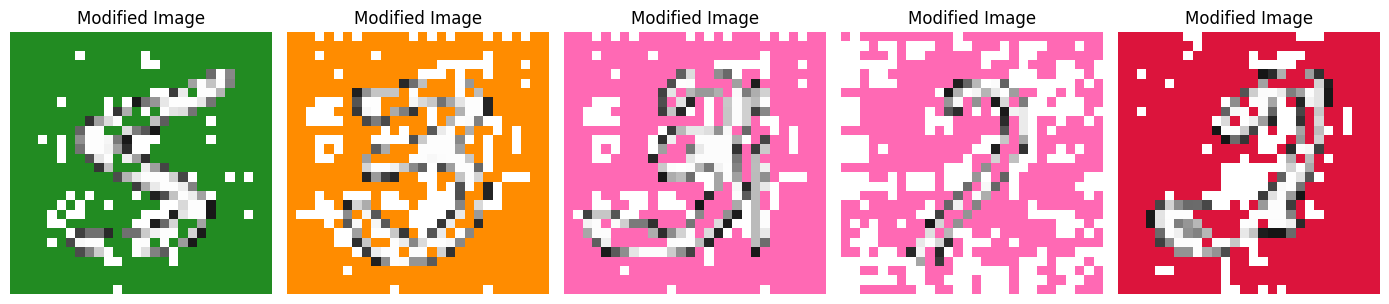

In [10]:
# ---------- MAIN LOOP (replace your code with this) ----------
modified_images = []
for path, diff in zip(image_files, diff_maps):
    pil = Image.open(path).convert("RGB" if in_ch == 3 else "L")
    x_vis = to_vis(pil).unsqueeze(0)                      # [1,C,H,W], [0,1]
    img_np = x_vis[0].permute(1,2,0).cpu().numpy()        # [H,W,3] or [H,W,1]

    # 1) detect background from edges
    bg_color, _is_bg = detect_background_color(img_np)

    # 2) select only the 40% most negative diffs (cap)
    #    ensure diff is [H,W] np array
    if isinstance(diff, torch.Tensor):
        diff_np = diff.detach().cpu().numpy()
    else:
        diff_np = diff
    if diff_np.ndim == 3:  # e.g., [H,W,1]
        diff_np = diff_np.squeeze()
    mask_40 = top_k_most_negative_mask(diff_np, frac=0.40)

    # 3) apply color rules within mask
    modified_img = apply_color_rules(img_np, mask_40, bg_color)

    modified_images.append(modified_img)

# show
fig, axes = plt.subplots(1, len(image_files), figsize=(14,4))
for ax, mod_img in zip(axes, modified_images):
    if mod_img.shape[2] == 1:
        ax.imshow(mod_img.squeeze(), cmap="gray")
    else:
        ax.imshow(mod_img)
    ax.set_title("Modified Image")
    ax.axis("off")
plt.tight_layout(); plt.show()


In [11]:
save_dir = challenge_dir / 'edited'
for modified_image, img_file in zip(modified_images, image_files):
    # save
    save_path = save_dir / img_file.name
    pil_img = to_pil(torch.tensor(modified_image).permute(2,0,1))  # C,H,W
    pil_img.save(save_path)    

---
### Any code you want to add, put it below this markdown cell

Podemos observar como los fondos rosas, verdes y naranjas solo son clases de números impares {1,3,5,7,9}. Morado azul y rojo solo son clases pares {0,2,4,6,8}.

---
## Check if you have passed the challenge 

In [12]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [13]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')


Edited 0_label5.png: Pred: 1, Label: 5, correct: False
Edit Percentage: 9.31%
Edited 1_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 19.13%
Edited 2_label3.png: Pred: 1, Label: 3, correct: False
Edit Percentage: 16.96%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 36.48%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 14.92%
